# Data Preprocessing

## Crime(보이스피싱) Data
- 분석 대상지역 : 대전광역시, 세종시

In [2]:
# package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from tqdm import tqdm

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

In [18]:
# csv load(7.1s)
KP2020 = pd.read_csv('data/KP2020.csv', encoding='cp949')
KP2021 = pd.read_csv('data/KP2021.csv', encoding='cp949')
NPA2020 = pd.read_csv('data/NPA2020.csv', encoding='cp949')

### 보이스피싱 범죄 Dataset Generate
- 사건코드 : EVT_CL_CD == 215 </br>
- 동일사건 제외 : SME_EVT_YN != Y

In [19]:
KP2020 = KP2020.loc[(KP2020.EVT_CL_CD == 215) & (KP2020.SME_EVT_YN != 'Y'),:]
KP2021 = KP2021.loc[(KP2021.EVT_CL_CD == 215) & (KP2021.SME_EVT_YN != 'Y'),:]
NPA2020 = NPA2020.loc[(NPA2020.EVT_CL_CD == 215) & (NPA2020.SME_EVT_YN != 'Y'),:]

In [20]:
# Datetime 통일
NPA2020['RECV_CPLT_DM'] = None
NPA2020['RECV_CPLT_DM'] = NPA2020['RECV_CPLT_DM'].astype('str')
NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype('str')
NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype('str')

NPA2020['RECV_CPLT_DM'] = [i + j.zfill(6) for i,j in NPA2020[['RECV_CPLT_DT','RECV_CPLT_TM']].values] # 시간 6자리로 코딩 후 병합
NPA2020 = NPA2020[NPA2020.columns.drop(['RECV_CPLT_DT','RECV_CPLT_TM'])]

In [21]:
KP2020['RECV_CPLT_DM'] = pd.to_datetime(KP2020['RECV_CPLT_DM'], yearfirst=True)
KP2021['RECV_CPLT_DM'] = pd.to_datetime(KP2021['RECV_CPLT_DM'], yearfirst=True)
NPA2020['RECV_CPLT_DM'] = pd.to_datetime(NPA2020['RECV_CPLT_DM'], yearfirst=True)

In [22]:
# 사용컬럼만 추출
cols = ['RECV_CPLT_DM', 'NPA_CL', 'RPTER_SEX', 'HPPN_X', 'HPPN_Y']
KP2020 = KP2020[cols]
KP2021 = KP2021[cols]
NPA2020 = NPA2020[cols]

In [23]:
# Merge
df_crime = pd.concat([KP2020, KP2021, NPA2020], axis=0).dropna(axis=0).sort_values(by='RECV_CPLT_DM')
df_crime = df_crime[~(df_crime.HPPN_X == 0)].reset_index(drop=True)

# to GeoDataFrame
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime['HPPN_X'], df_crime['HPPN_Y']), crs='WGS84')
gdf_crime = gdf_crime[gdf_crime.columns.drop(['HPPN_X','HPPN_Y'])]

In [24]:
gdf_crime = gdf_crime.loc[(gdf_crime.RECV_CPLT_DM < pd.to_datetime('2022-01-01')) & (pd.to_datetime('2021-01-01') <= gdf_crime.RECV_CPLT_DM), :] # 2021년 데이터만 추출

In [25]:
gdf_crime = gdf_crime.loc[gdf_crime.NPA_CL.isin([13,31]),:] # 충남(19) 제외, 세종(31), 대전(13) 한정 데이터 추출
gdf_crime = gdf_crime.to_crs(epsg=5181)

gdf_crime.to_file('data/gdf_crime_full.gpkg',index=False)

gdf_crime_DJ = gdf_crime.loc[gdf_crime.NPA_CL == 13, : ]
gdf_crime_SJ = gdf_crime.loc[gdf_crime.NPA_CL == 31, : ]
gdf_crime_DJ.to_file('data/gdf_crime_DJ.gpkg', index=False)
gdf_crime_SJ.to_file('data/gdf_crime_SJ.gpkg', index=False)

## Geographic Processing

### 행정구역

In [27]:
gdf_crime = gpd.read_file('data/gdf_crime_full.gpkg')

In [28]:
# 행정구역 data
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949')
sejong = sejong.to_crs(epsg=5181)
sejong['시도'] = '세종'

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949')
daejeon = daejeon.to_crs(epsg=5181)
daejeon['시도'] = '대전'

# chungnam = gpd.read_file('data/ADM_AREA/충남/LSMD_ADM_SECT_UMD_44.shp', encoding='cp949')
# chungnam = chungnam.to_crs(epsg=5181)
# chungnam['시도'] = '충남'
# chungnam.total_bounds

In [29]:
# # 충남지역은 도서지역이 포함되므로 육지(태안군 소원면까지를 왼쪽 기준으로 잡음)만 행정구역으로 사용
# from shapely.geometry import MultiPolygon
# from operator import itemgetter

# 소원면 = chungnam.loc[chungnam.EMD_NM == '소원면','geometry']
# xmin, _, _, _ = 소원면.total_bounds
# dropls = []
# for i,g_i in enumerate(tqdm(chungnam.geometry)):
#     if type(g_i) == MultiPolygon:
#         keep_i = list(range(len(g_i.geoms)))
#         for j, g_j in enumerate(g_i.geoms):
#             if g_j.bounds[0] < xmin:
#                 keep_i.remove(j)
        
#         chungnam.geometry[i] = MultiPolygon(list(itemgetter(*keep_i)(g_i.geoms)))
#     else:
#         if g_i.bounds[0] < xmin:
#             dropls.append(i)

# chungnam.total_bounds

In [30]:
# whole_area = pd.concat([sejong, daejeon, chungnam], axis=0)
# whole_area.to_file('data/whole_adm_area.gpkg', index=False)

whole_area = pd.concat([sejong, daejeon], axis=0)
whole_area = whole_area.to_crs(epsg=5181)
whole_area.to_file('data/whole_adm_대전세종.gpkg', index=False)

### Griding

In [199]:
# # 격자생성
# '''
# 지역과 intersect되는 격자 추출
# '''
# from shapely.geometry import Polygon

# whole_area_5181 = whole_area.to_crs(epsg=5181)
# xmin, ymin, xmax, ymax = whole_area_5181.total_bounds # Total bound : 최대지점

# length = 1000 # 가로/세로 1000m 격자
# wide = 1000

# cols = list(np.arange(xmin, xmax + wide, wide))
# rows = list(np.arange(ymin, ymax + length, length))

# polygons = []
# for x in tqdm(cols[:-1]):
#     for y in rows[:-1]:
#         polygon_i = Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
#         if whole_area_5181.geometry.intersects(polygon_i).any(): # Intersect(교차) 여부 파악
#             polygons.append(polygon_i)
#         else:
#             pass

# grid = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:5181').to_crs('WGS84')
# grid.to_file('data/grid.gpkg', index=False)
# print('격자개수 : ' + str(len(grid)))

In [31]:
# 격자 > SGIS 시스템의 1000M 격자 사용
grid = gpd.read_file('data/CENSUS/grid.gpkg')

In [32]:
# 각 접수사건 포함 행정구역 추출
from tqdm import tqdm

gdf_crime['ADM_AREA'] = 0 # 세종/대전 지역(whole area) 외 발생사건은 행정구역 0으로 표기
for i in tqdm(range(len(gdf_crime))):
    arr_i = np.where(whole_area.geometry.intersects(gdf_crime.geometry[i]))[0]
    if len(arr_i) > 0 :
        gdf_crime.iat[i, 4] = whole_area.iat[arr_i[0],4] # GID 대입

100%|██████████| 4237/4237 [00:02<00:00, 2079.64it/s]


In [33]:
# 대상지역 외 사건 제외
gdf_crime = gdf_crime[~(gdf_crime.ADM_AREA == 0)]
len(gdf_crime)

4196

In [34]:
# 각 지역별로 분리
gdf_crime_daejeon = gdf_crime.loc[gdf_crime.ADM_AREA.isin(daejeon.GID),:]
gdf_crime_sejong = gdf_crime.loc[gdf_crime.ADM_AREA.isin(sejong.GID),:]

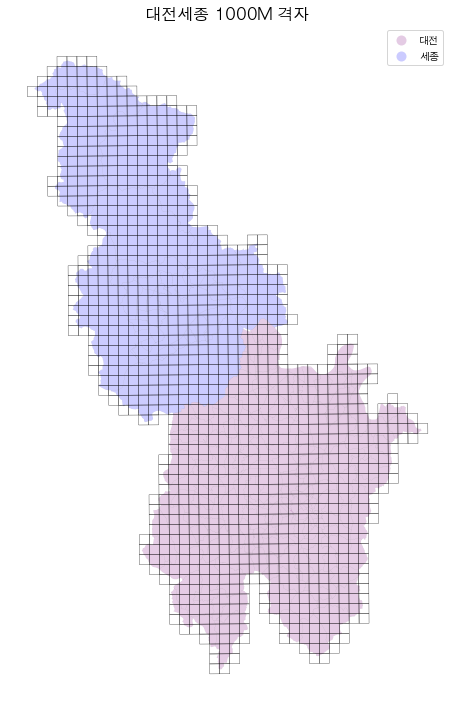

In [35]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
grid.boundary.plot(ax=ax, zorder=2, color='black', linewidth=0.3)
# gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.title('대전세종 1000M 격자', fontsize=16)
plt.tight_layout()
plt.show()

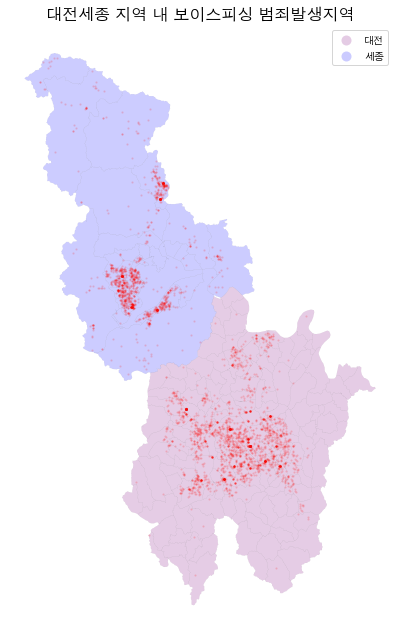

In [36]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.title('대전세종 지역 내 보이스피싱 범죄발생지역', fontsize=16)
plt.savefig('plot/대전세종 지역 내 보이스피싱 범죄발생지역.png', facecolor = 'white')
plt.tight_layout()
plt.show()

In [37]:
gdf_crime.to_file('data/gdf_crime_adm.gpkg', index=False)
gdf_crime_daejeon.to_file('data/gdf_crime_adm_DJ.gpkg', index=False)
gdf_crime_sejong.to_file('data/gdf_crime_adm_SJ.gpkg', index=False)

## 외부데이터 처리

### ATM/은행 등 현금인출기 위치정보 처리
- Geocoding

In [207]:
geo_local = Nominatim(user_agent='South Korea') # 지오코더
regions = ['대전광역시','세종특별자치시']

def geocoder(region):
    df = pd.read_csv(f'data/{region} 현금인출기.csv')
    df['Y'] = 0 # 위도
    df['X'] = 0 # 경도
    
    for idx, add in enumerate(tqdm(df.ADD)):
        try:
            geo = geo_local.geocode(' '.join(add.split(' ')[0:4]))
            lat = geo.latitude
            lon = geo.longitude
        except:
            lat, lon = [0, 0]

        df.iat[idx, 2] = lat
        df.iat[idx, 3] = lon

    df.to_csv(f'data/{region} 현금인출기.csv', index=False)

In [208]:
# # Geocoding
# for region in regions:
#     geocoder(region=region)

In [39]:
# load
df_atm = pd.concat([pd.read_csv('data/대전광역시 현금인출기.csv'),pd.read_csv('data/세종특별자치시 현금인출기.csv')]).reset_index(drop=True)
df_atm = df_atm[~(df_atm.X == 0)]

df_atm = gpd.GeoDataFrame(df_atm['NAME'], geometry=gpd.points_from_xy(df_atm.X, df_atm.Y), crs='WGS84').to_crs(epsg=5181)

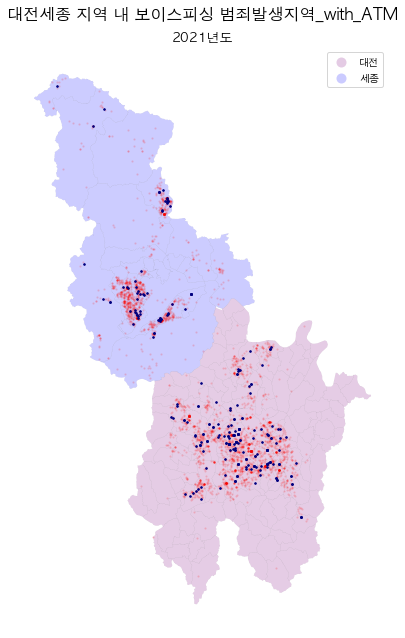

In [40]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['purple','blue']), alpha=0.2, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)
df_atm.geometry.plot(ax=ax, zorder=3, color='navy', markersize=2.5)

ax.set_axis_off()

plt.suptitle('대전세종 지역 내 보이스피싱 범죄발생지역_with_ATM', fontsize=16)
plt.title('2021년도', fontsize=13)
plt.savefig('plot/대전세종 지역 내 보이스피싱 범죄발생지역_with_ATM.png', facecolor = 'white')
plt.tight_layout()
plt.show()

### 상권정보

In [211]:
df_commercial = pd.concat([pd.read_csv('data/외부데이터/소상공인시장진흥공단_상가(상권)정보_대전_202209.csv'),pd.read_csv('data/외부데이터/소상공인시장진흥공단_상가(상권)정보_세종_202209.csv')])
df_commercial = df_commercial[['상권업종대분류명','상권업종중분류명','상권업종소분류명','경도','위도']].reset_index(drop=True)
df_commercial = gpd.GeoDataFrame(df_commercial[['상권업종대분류명','상권업종중분류명','상권업종소분류명']], geometry=gpd.points_from_xy(df_commercial.경도, df_commercial.위도), crs='WGS84').to_crs(epsg=5181)

In [212]:
conv_store = df_commercial.loc[df_commercial.상권업종소분류명 == '편의점', :].reset_index(drop=True) # 편의점 위치정보
df_commercial = df_commercial.loc[df_commercial.상권업종소분류명 != '편의점', :].reset_index(drop=True)

In [213]:
commercial_cols = df_commercial.상권업종대분류명.unique()

### 버스정류장 위치정보

In [214]:
df_bus = pd.read_csv('data/외부데이터/국토교통부_전국 버스정류장 위치정보_20221012/bus.csv', usecols=['위도','경도','도시명'])
df_bus = df_bus.loc[df_bus.도시명.isin(['세종특별시','대전광역시']),:]
df_bus = gpd.GeoDataFrame(df_bus['도시명'], geometry=gpd.points_from_xy(df_bus.경도,df_bus.위도), crs='WGS84').to_crs(epsg=5181)

### 격자에 병합

In [215]:
# ATM
grid['ATM'] = 0
for i in range(len(df_atm)):
    where = np.where(grid.geometry.intersects(df_atm.iat[i,1]))[0]
    if len(where) > 0 :
        idx = where[0]
        grid.iat[idx, 2] += 1
print(grid.ATM.sum())

257


In [216]:
# Busstop
grid['Busstop'] = 0
for i in tqdm(range(len(df_bus))):
    where = np.where(grid.geometry.intersects(df_bus.iat[i,1]))[0]
    if len(where) > 0 :
        idx = where[0]
        grid.iat[idx, 3] += 1
print(grid.Busstop.sum())

100%|██████████| 5838/5838 [00:08<00:00, 651.52it/s]

4449


In [217]:
# 편의점
grid['Convenience'] = 0
for i in tqdm(range(len(conv_store))):
    where = np.where(grid.geometry.intersects(conv_store.iat[i,3]))[0]
    if len(where) > 0 :
        idx = where[0]
        grid.iat[idx, 4] += 1
print(grid.Convenience.sum())

100%|██████████| 1503/1503 [00:02<00:00, 649.10it/s]

1503


In [218]:
df_commercial

,상권업종대분류명,상권업종중분류명,상권업종소분류명,geometry
0,생활서비스,자동차/이륜차,자동차정비/카센타,POINT (235265.133 325214.548)
1,소매,기타판매업,농기구판매,POINT (234105.447 312801.010)
2,학문/교육,학원-보습교습입시,학원-입시,POINT (237166.817 315220.961)
3,음식,한식,한식/백반/한정식,POINT (228725.155 319537.152)
4,음식,유흥주점,호프/맥주,POINT (238573.183 314139.359)
...,...,...,...,...
86041,소매,화장품소매,화장품판매점,POINT (222263.718 331480.431)
86042,음식,커피점/카페,커피전문점/카페/다방,POINT (223542.478 334405.991)
86043,소매,가방/신발/액세서리,액세서리판매,POINT (221859.944 335404.618)
86044,소매,자동차/자동차용품,중고타이어판매,POINT (223303.296 331627.233)


In [234]:
# 상권(대분류업종)
grid[commercial_cols] = 0

for i in tqdm(range(len(df_commercial))):
    where = np.where(grid.geometry.intersects(df_commercial.iat[i,3]))[0]
    if len(where) > 0 :
        idx = where[0]
        col = df_commercial.iat[i,0]
        col_idx = np.where(col == grid.columns)[0][0]
        grid.iat[idx, col_idx] += 1

grid[commercial_cols].sum()

100%|██████████| 86046/86046 [02:27<00:00, 582.67it/s]


생활서비스       16766
소매          26565
학문/교육        6360
음식          28581
관광/여가/오락     2179
부동산          3912
스포츠          1043
숙박            640
dtype: int64

## CENSUS DATA 병합

In [229]:
df_census = gpd.read_file('data/CENSUS/census.gpkg').set_index('index')

In [236]:
df_full = grid.set_index('GRID_1K_CD').join(df_census[df_census.columns.drop('geometry')])
df_full.to_file('df_full.gpkg')

In [238]:
df_full.head(3) # Final Dataset

,geometry,ATM,Busstop,Convenience,생활서비스,소매,학문/교육,음식,관광/여가/오락,부동산,스포츠,숙박,in_age_001,in_age_002,in_age_003,in_age_004,in_age_005,in_age_006,in_age_007,in_age_008,in_age_009,in_age_010,in_age_011,in_age_012,in_age_013,in_age_014,in_age_015,in_age_016,in_age_017,in_age_018,in_age_019,in_age_020,in_age_021,in_age_031,in_age_032,in_age_033,in_age_034,in_age_035,in_age_036,in_age_037,in_age_038,in_age_039,in_age_040,in_age_041,in_age_042,in_age_043,in_age_044,in_age_045,in_age_046,in_age_047,in_age_048,in_age_049,in_age_050,in_age_051,in_age_061,in_age_062,in_age_063,in_age_064,in_age_065,in_age_066,in_age_067,in_age_068,in_age_069,in_age_070,in_age_071,in_age_072,in_age_073,in_age_074,in_age_075,in_age_076,in_age_077,in_age_078,in_age_079,in_age_080,in_age_081,to_in_001,to_in_007,to_in_008
GRID_1K_CD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
다바8400,"POLYGON ((228963.099 299953.355, 228957.943 30...",0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
다바8500,"POLYGON ((229963.493 299958.511, 229958.337 30...",0,5,0,0,0,0,2,0,0,0,3,NaN,NaN,0.0,5.0,5.0,0.0,5.0,NaN,0.0,5.0,8.0,5.0,8.0,0.0,5.0,5.0,8.0,NaN,5.0,0.0,NaN,NaN,NaN,0.0,5.0,5.0,0.0,5.0,NaN,0.0,0.0,5.0,5.0,8.0,NaN,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,5.0,5.0,0.0,5.0,0.0,0.0,5.0,8.0,NaN,5.0,0.0,NaN,48.0,23.0,23.0
다바8600,"POLYGON ((230963.889 299963.667, 230958.733 30...",0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_full = gpd.read_file('df_full.gpkg')
df_full

,GRID_1K_CD,ATM,Busstop,Convenience,생활서비스,소매,학문/교육,음식,관광/여가/오락,부동산,스포츠,숙박,in_age_001,in_age_002,in_age_003,in_age_004,in_age_005,in_age_006,in_age_007,in_age_008,in_age_009,in_age_010,in_age_011,in_age_012,in_age_013,in_age_014,in_age_015,in_age_016,in_age_017,in_age_018,in_age_019,in_age_020,in_age_021,in_age_031,in_age_032,in_age_033,in_age_034,in_age_035,in_age_036,in_age_037,in_age_038,in_age_039,in_age_040,in_age_041,in_age_042,in_age_043,in_age_044,in_age_045,in_age_046,in_age_047,in_age_048,in_age_049,in_age_050,in_age_051,in_age_061,in_age_062,in_age_063,in_age_064,in_age_065,in_age_066,in_age_067,in_age_068,in_age_069,in_age_070,in_age_071,in_age_072,in_age_073,in_age_074,in_age_075,in_age_076,in_age_077,in_age_078,in_age_079,in_age_080,in_age_081,to_in_001,to_in_007,to_in_008,geometry
0,다바8400,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((228963.099 299953.355, 228957.943 30..."
1,다바8500,0,5,0,0,0,0,2,0,0,0,3,NaN,NaN,0.0,5.0,5.0,0.0,5.0,NaN,0.0,5.0,8.0,5.0,8.0,0.0,5.0,5.0,8.0,NaN,5.0,0.0,NaN,NaN,NaN,0.0,5.0,5.0,0.0,5.0,NaN,0.0,0.0,5.0,5.0,8.0,NaN,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,5.0,5.0,0.0,5.0,0.0,0.0,5.0,8.0,NaN,5.0,0.0,NaN,48.0,23.0,23.0,"POLYGON ((229963.493 299958.511, 229958.337 30..."
2,다바8600,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((230963.889 299963.667, 230958.733 30..."
3,다바9300,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,NaN,5.0,5.0,0.0,NaN,NaN,NaN,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.0,5.0,0.0,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,8.0,5.0,"POLYGON ((237966.690 299999.757, 237961.534 30..."
4,다바9400,0,2,0,0,0,0,4,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,"POLYGON ((238967.095 300004.913, 238961.938 30..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,라바0224,0,3,0,0,0,0,4,0,0,0,0,NaN,NaN,0.0,0.0,5.0,5.0,NaN,0.0,0.0,5.0,8.0,8.0,13.0,8.0,5.0,0.0,5.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,5.0,0.0,NaN,0.0,0.0,5.0,8.0,5.0,8.0,5.0,5.0,0.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,5.0,5.0,5.0,8.0,5.0,0.0,NaN,0.0,5.0,0.0,NaN,NaN,58.0,38.0,23.0,"POLYGON ((246846.310 324056.093, 246841.127 32..."
1145,라바0324,0,3,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,5.0,5.0,5.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,8.0,8.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,NaN,NaN,0.0,5.0,NaN,5.0,0.0,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,38.0,18.0,18.0,"POLYGON ((247846.724 324061.276, 247841.541 32..."
1146,라바0225,0,2,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,5.0,5.0,5.0,"POLYGON ((246841.127 325056.507, 246835.943 32..."
1147,라바0027,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,